<a href="https://colab.research.google.com/github/bjk95/Machine-Learning-for-Finance/blob/master/embeddings_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sales Forecaster using embeddings

This model will create a tensorflow model from multiple inputs used to create product level predictions of what indivudual customers will purchase.

In [113]:
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, Activation, LSTM, Input, Embedding, Reshape
from tensorflow.python.keras.layers.merge import Dot, Concatenate, Multiply
from tensorflow.python.keras.models import Model, load_model
from tensorflow.python.keras.callbacks import TensorBoard
import tensorflow.keras.backend as K
from tensorflow.python.keras.initializers import Constant
from tensorflow.python.keras.layers.advanced_activations import LeakyReLU
from tensorflow.python.keras.layers import ReLU, ELU
from tensorflow.python.keras.callbacks import ModelCheckpoint
from tensorflow.python.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler 
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow import set_random_seed
from seaborn import distplot
from scipy.stats import describe
from IPython.display import SVG
from tensorflow.python.keras.utils.vis_utils import model_to_dot
from tensorflow.python.keras.utils import plot_model
import pydotplus as pydot
import time
import pickle
import os
import pprint

#!pip install talos
#import talos as ta

if 'COLAB_TPU_ADDR' not in os.environ:
  print('ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!')
else:
  tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  print ('TPU address is', tpu_address)

  with tf.Session(tpu_address) as session:
    devices = session.list_devices()
    
  print('TPU devices:')
  pprint.pprint(devices)

try:
  from google.colab import drive
  drive.mount('/gdrive')
  main_path = '/gdrive/My Drive/sales_forecaster'
  
except:
  main_path = None
  
epochs = 20


TPU address is grpc://10.14.22.146:8470
TPU devices:
[_DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:CPU:0, CPU, -1, 14616927689176665043),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 4436853064576881343),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 12483226646210481779),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 16064768687788555436),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 14485497092262831473),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 9431844963749294783),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 16851256335783094820),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 12810576241754971467),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 1430064601

In [68]:
print(os.listdir('/gdrive/My Drive/sales_forecaster'))

['models', 'histories', 'material_codes.csv', 'customer_codes.csv', 'top20.csv']


# Importing data and data exploration

In this section we will import a sample set of the Pact sales data stored in a .csv, perform basic data exploration and reformat data for training.

In [69]:
summary = pd.read_csv('/gdrive/My Drive/sales_forecaster/top20.csv')
print(summary.describe())
print(summary.head())

        Unnamed: 0         custID   materialID  PeriodBlock          order
count  6612.000000    6612.000000  6612.000000  6612.000000    6612.000000
mean   3305.500000   33246.263158  3268.275862     6.500000    1564.312231
std    1908.864322   50129.807722  1710.808703     3.452314   20352.675674
min       0.000000    2203.000000    20.000000     1.000000       0.000000
25%    1652.750000   10685.000000  1897.000000     3.750000       0.000000
50%    3305.500000   17048.000000  3729.000000     6.500000      73.951202
75%    4958.250000   28975.000000  4883.000000     9.250000     397.661068
max    6611.000000  211793.000000  5409.000000    12.000000  777285.494656
   Unnamed: 0  custID  materialID  PeriodBlock  order
0           0    2203          78            1    0.0
1           1    2203          78            2    0.0
2           2    2203          78            3    0.0
3           3    2203          78            4    0.0
4           4    2203          78            5    0.0


In [70]:
customer_codes = pd.read_csv('/gdrive/My Drive/sales_forecaster/customer_codes.csv')
print(customer_codes.head())

material_codes = pd.read_csv('/gdrive/My Drive/sales_forecaster/material_codes.csv')
print(material_codes.head())

   customerID  custID IndustryKey                CustomerName
0           0    2025        V121                FCC TAURANGA
1           1    2101        V033     VISY  - CREDIT SERVICES
2           2    2202        V121           VIP - HEAD OFFICE
3           3    2206        V121  VIP PLASTICS  - CHELTENHAM
4           4    2214        V121       VIP TUBES - NTH ROCKS
   materialID         prodID                  MaterialName
0           0             AH  Agribusiness & Horticultural
1           1          AHC74                    HERBICIDES
2           2      AHC74C533                        LIQUID
3           3  AHC74C533ZZZZ                   Unallocated
4           4      AHC74C546                        POWDER


In [71]:
summary = pd.merge(summary, customer_codes, on='custID')
summary = pd.merge(summary, material_codes, on='materialID')
print(summary.head())
print(summary.shape)

   Unnamed: 0  custID  materialID  PeriodBlock  order  customerID IndustryKey  \
0           0    2203          78            1    0.0        5290        V121   
1           1    2203          78            2    0.0        5290        V121   
2           2    2203          78            3    0.0        5290        V121   
3           3    2203          78            4    0.0        5290        V121   
4           4    2203          78            5    0.0        5290        V121   

               CustomerName prodID           MaterialName  
0  VIP STEEL  -   TRUGANINA  CDB29  Food Beverage Closure  
1  VIP STEEL  -   TRUGANINA  CDB29  Food Beverage Closure  
2  VIP STEEL  -   TRUGANINA  CDB29  Food Beverage Closure  
3  VIP STEEL  -   TRUGANINA  CDB29  Food Beverage Closure  
4  VIP STEEL  -   TRUGANINA  CDB29  Food Beverage Closure  
(6612, 10)


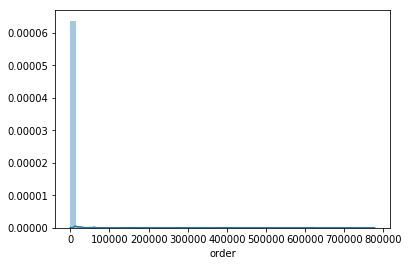

In [72]:
distplot(summary.order)

Here we can see that the value of product orders follow an extreme Pareto distribution. This make the data difficult to train on, therefore we shall try a log transformation to see if that gives us more meaningful data.

*N.B. We will have to reverse this transform at the end to rescale the data.*

[0.         0.         0.         ... 4.25245315 4.51219104 4.53545929]


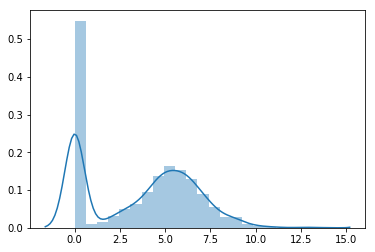

In [73]:
def log(data):
  x = np.ma.log(np.array(data))
  print(x.filled(0))
  
  return x

distplot(log(summary.order).clip(0))

Now we have applied the log tranformation we can see that our data follows a much more consistently distributed pattern. As our data includes 0s we  defined a function that imposes a log transformation while ignoring 0s. To do so, we used a masked numpy array.

In [0]:
def scale(data):
  data = data - min(data)
  data = data / max(data)
  
  return data

In [75]:
customers = summary.custID.unique()
customer_map = {i:val for i,val in enumerate(customers)}
inverse_customer_map = {val:i for i,val in enumerate(customers)}
materials = summary.materialID.unique()
material_map = {i:val for i,val in enumerate(materials)}
inverse_material_map = {val:i for i,val in enumerate(materials)}

summary['period_material'] = summary['materialID'].map(str) + 'M' + summary['PeriodBlock'].map(str)

materials = summary.period_material.unique()
material_map = {i:val for i,val in enumerate(materials)}
inverse_period_material_map = {val:i for i,val in enumerate(materials)}

df = pd.DataFrame()
df["old_customer_id"] = scale(summary['custID'])
df["customer_name"] = summary['CustomerName']
df["customer_id"] = scale(summary["custID"].map(inverse_customer_map))
df["old_material_id"] = scale(summary["materialID"]) # copying for join with metadata
df["material_name"] = summary['MaterialName']
df["material_id"] = scale(summary["materialID"].map(inverse_material_map))
df['period_material'] = scale(summary.period_material.map(inverse_period_material_map))
df['order'] = log(summary.order).clip(0)
df['order'] = scale(df['order'])


print("Descriptive statistics of our transformed data \n")
print(df.describe())
print("\n An example of the top 10 entries of our data \n")
print(df.head(10))

[0.         0.         0.         ... 4.25245315 4.51219104 4.53545929]
Descriptive statistics of our transformed data 

       old_customer_id  customer_id  old_material_id  material_id  \
count      6612.000000  6612.000000      6612.000000  6612.000000   
mean          0.148114     0.329544         0.602760     0.315395   
std           0.239180     0.265417         0.317463     0.269106   
min           0.000000     0.000000         0.000000     0.000000   
25%           0.040469     0.105263         0.348302     0.078947   
50%           0.070829     0.263158         0.688254     0.263158   
75%           0.127735     0.473684         0.902394     0.467105   
max           1.000000     1.000000         1.000000     1.000000   

       period_material        order  
count      6612.000000  6612.000000  
mean          0.316502     0.265871  
std           0.267499     0.218465  
min           0.000000     0.000000  
25%           0.081199     0.000000  
50%           0.263760     0.

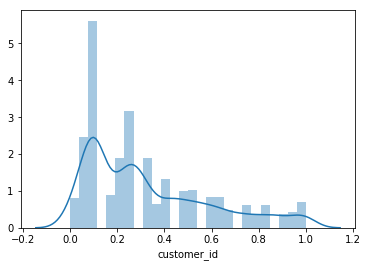

In [76]:
distplot(df.customer_id)

Here we can see there are no major anomalies in our customer ID set

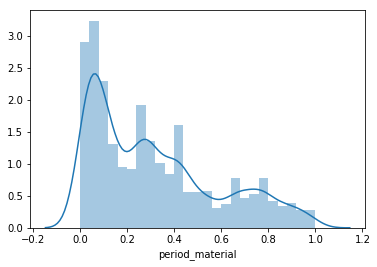

In [77]:
distplot(df.period_material)

Here we can see there are no major anomalies in our customer ID set.

Now we can move onto creating our model.

# Matrix Factorisation approach

Here we will create our first simple model based on matrix factorisation. We create here an embedding for customers and materials. The dot product between these two items give us our predictions

INFO:tensorflow:Querying Tensorflow master (grpc://10.14.22.146:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 14616927689176665043)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 4436853064576881343)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 12483226646210481779)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 16064768687788555436)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 14485497092262831473)
INFO:tensorflow:*** Available Device: _DeviceAttribute

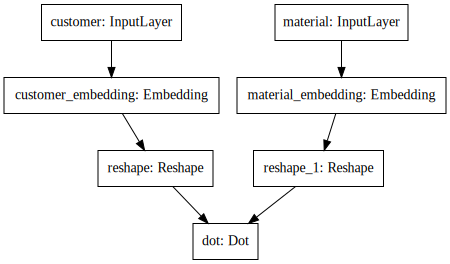

In [78]:
K.clear_session()

customer_id_input = Input(shape=[1], name='customer')
material_id_input = Input(shape=[1], name = 'material')

embedding_size=30

customer_embedding = Embedding(output_dim=embedding_size, input_dim=df.shape[0],
                             input_length=1, name='customer_embedding')(customer_id_input)
material_embedding = Embedding(output_dim=embedding_size, input_dim=df.shape[0],
                             input_length=1, name='material_embedding')(material_id_input)

customer_vecs = Reshape([embedding_size])(customer_embedding)
material_vecs = Reshape([embedding_size])(material_embedding)

y = Dot(1, normalize=False)([customer_vecs, material_vecs])

model = Model(inputs=[customer_id_input, material_id_input], outputs=y)

TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
tf.logging.set_verbosity(tf.logging.INFO)

model = tf.contrib.tpu.keras_to_tpu_model(
    model,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)))

model.compile(loss='mse',
              optimizer="adam"
             )

print(model.summary())
SVG(model_to_dot(model).create(prog='dot', format='svg'))

Here we have a representation of our model. It takes two inputs which are then embedded and reshaped before the dot product of the two is taken.

Below we define our callback to take checkpoints throughout the models training

In [0]:
save_path = main_path + "/models"
mytime = time.strftime("%Y_%m_%d_%H_%M")
modname = 'matrix_facto_50_' + mytime 
thename = save_path + '/' + modname + '.h5'
mcheck = ModelCheckpoint(thename  , monitor='val_loss', save_best_only=True)

Now we can train the model

In [80]:
history = model.fit([df["customer_id"], df["period_material"]]
                    , df["order"]
                    , batch_size=64 * 8, epochs=epochs
                    , validation_split=0.1
                    , callbacks=[mcheck]
                    , shuffle=True)

with open(main_path + '/histories/' + modname + '.pkl' , 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

Train on 6612 samples, validate on 662 samples
Epoch 1/20
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(64,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(64, 1), dtype=tf.float32, name='customer_10'), TensorSpec(shape=(64, 1), dtype=tf.float32, name='material_10'), TensorSpec(shape=(64, 1), dtype=tf.float32, name='dot_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Cloning Adam {'lr': 0.0010000000474974513, 'beta_1': 0.8999999761581421, 'beta_2': 0.9990000128746033, 'decay': 0.0, 'epsilon': 1e-07, 'amsgrad': False}
INFO:tensorflow:Remapping placeholder for customer
INFO:tensorflow:Remapping placeholder for material
INFO:tensorflow:KerasCrossShard: <tensorflow.python.keras.optimizers.Adam object at 0x7f55db2c9860> []
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 1.422675609588623 secs
INFO:tensorflow:Setting weights on TPU model.
INFO:tensorflow:CPU -> TPU lr: 0.0

Now we can examine the historiy file

/gdrive/My Drive/sales_forecaster/histories/matrix_facto_50_2019_04_24_01_04.pkl


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
loss,0.11015,0.099266,0.085898,0.070471,0.057037,0.049381,0.047871,0.048108,0.047885,0.047718,0.047686,0.047688,0.047682,0.047698,0.047664,0.047692,0.047674,0.047677,0.047665,0.047684
val_loss,0.10747,0.095655,0.081261,0.066667,0.056417,0.053248,0.053725,0.053599,0.053086,0.052862,0.052795,0.052793,0.052803,0.052765,0.052754,0.052748,0.052753,0.052786,0.052753,0.052721


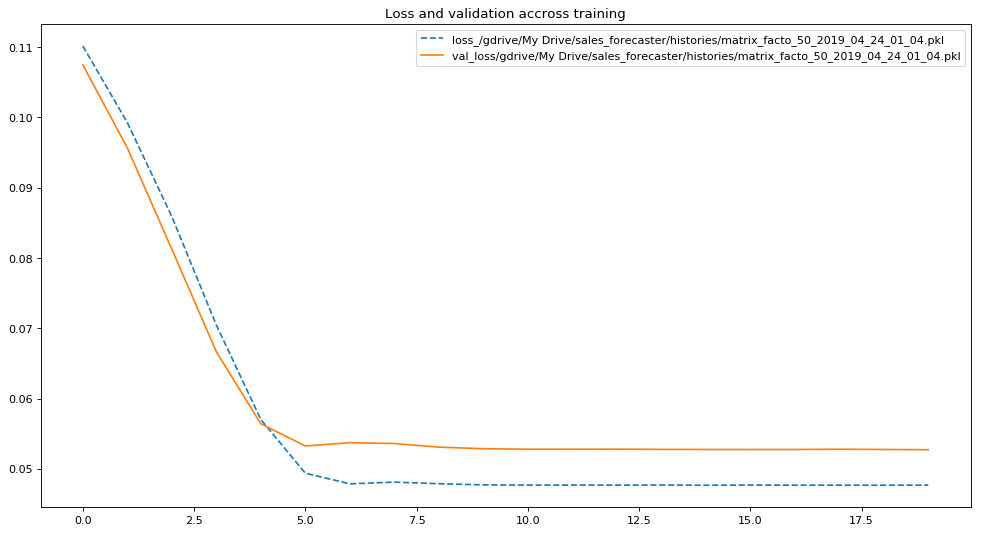

In [81]:
histories = [(main_path + '/histories/' + modname + '.pkl')]

plt.figure(num=None, figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')

for val in histories:
    print(val)
    with open(val , 'rb') as file_pi:
        thepickle = pickle.load(file_pi)
        plt.plot(thepickle["loss"],label ='loss_' + val,linestyle='--')
        plt.plot(thepickle["val_loss"],label='val_loss' + val)
        plt.legend(loc='upper right')
        plt.title("Loss and validation accross training")
        

pd.DataFrame(thepickle,columns =['loss','val_loss']).head(20).transpose()

# Deep keras model

The architecture above is trying to predict purchases by performing a dot product. We can relax the dot assumption and instead use a oconcatnation layer followed by a dense layer. This means that instead of relying on a simple dot product, the network can find itself the way it want to combine the data non-linearly.

To do so, we shall use a two layer deep neural network using tensorflow's high-level API, keras. 

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
customer (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
material (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
customer_embedding (Embedding)  (None, 1, 30)        198360      customer[0][0]                   
__________________________________________________________________________________________________
material_embedding (Embedding)  (None, 1, 30)        198360      material[0][0]                   
__________________________________________________________________________________________________
reshape (R

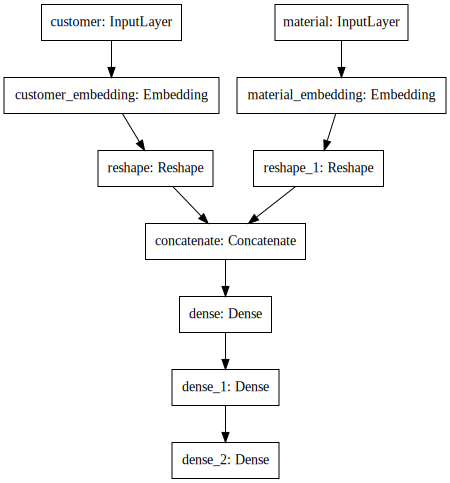

In [82]:
K.clear_session()

customer_id_input = Input(shape=[1], name='customer')
material_id_input = Input(shape=[1], name = 'material')

embedding_size=30

customer_embedding = Embedding(output_dim=embedding_size, input_dim=df.shape[0],
                             input_length=1, name='customer_embedding')(customer_id_input)
material_embedding = Embedding(output_dim=embedding_size, input_dim=df.shape[0],
                             input_length=1, name='material_embedding')(material_id_input)

customer_vecs = Reshape([embedding_size])(customer_embedding)
material_vecs = Reshape([embedding_size])(material_embedding)

input_vecs = Concatenate()([customer_vecs, material_vecs])

d1 = Dense(64, activation='relu')(input_vecs)
d2 = Dense(32, activation='relu')(d1)

y = Dense(1)(d2)

model = Model(inputs=[customer_id_input, material_id_input], outputs=y)
model.compile(optimizer='adam', loss='mse')

print(model.summary())
SVG(model_to_dot(model).create(prog='dot', format='svg'))

Here we have a representation of our model. It takes two inputs which are then embedded and reshaped before being concatenated and fed into a 2 layer deep neural network, before a final deep layer. 

Below we define our callback to take checkpoints throughout the models training

In [0]:
save_path = main_path + "/models"
mytime = time.strftime("%Y_%m_%d_%H_%M")
modname = 'dense_facto_50_' + mytime 
thename = save_path + '/' + modname + '.h5'
mcheck = ModelCheckpoint(thename  , monitor='val_loss', save_best_only=True)

Now we can train our deep model

In [84]:
history = model.fit([df["customer_id"], df["material_id"]]
                    , df["order"]
                    , batch_size=128 * 8, epochs=epochs
                    , validation_split=0.1
                    , callbacks=[mcheck]
                    , shuffle=True)

with open(main_path + '/histories/' + modname + '.pkl' , 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

Train on 5950 samples, validate on 662 samples
Epoch 1/20
5950/5950 [==============================] - 1s 122us/sample - loss: 0.1022 - val_loss: 0.0859
Epoch 2/20
5950/5950 [==============================] - 0s 24us/sample - loss: 0.0718 - val_loss: 0.0647
Epoch 3/20
5950/5950 [==============================] - 0s 35us/sample - loss: 0.0540 - val_loss: 0.0545
Epoch 4/20
5950/5950 [==============================] - 0s 13us/sample - loss: 0.0479 - val_loss: 0.0554
Epoch 5/20
5950/5950 [==============================] - 0s 12us/sample - loss: 0.0494 - val_loss: 0.0559
Epoch 6/20
5950/5950 [==============================] - 0s 22us/sample - loss: 0.0486 - val_loss: 0.0536
Epoch 7/20
5950/5950 [==============================] - 0s 36us/sample - loss: 0.0475 - val_loss: 0.0530
Epoch 8/20
5950/5950 [==============================] - 0s 29us/sample - loss: 0.0475 - val_loss: 0.0529
Epoch 9/20
5950/5950 [==============================] - 0s 31us/sample - loss: 0.0474 - val_loss: 0.0526
Epoch 1

/gdrive/My Drive/sales_forecaster/histories/dense_facto_50_2019_04_24_01_05.pkl


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
loss,0.102226,0.071829,0.054004,0.047894,0.049408,0.048583,0.047464,0.047457,0.047374,0.047195,0.047216,0.047185,0.047178,0.047166,0.047162,0.047164,0.047177,0.047165,0.047160,0.047164
val_loss,0.085885,0.064732,0.054549,0.055392,0.055947,0.053629,0.053017,0.052902,0.052645,0.052658,0.052563,0.052411,0.052382,0.052383,0.052375,0.052353,0.052326,0.052343,0.052342,0.052347


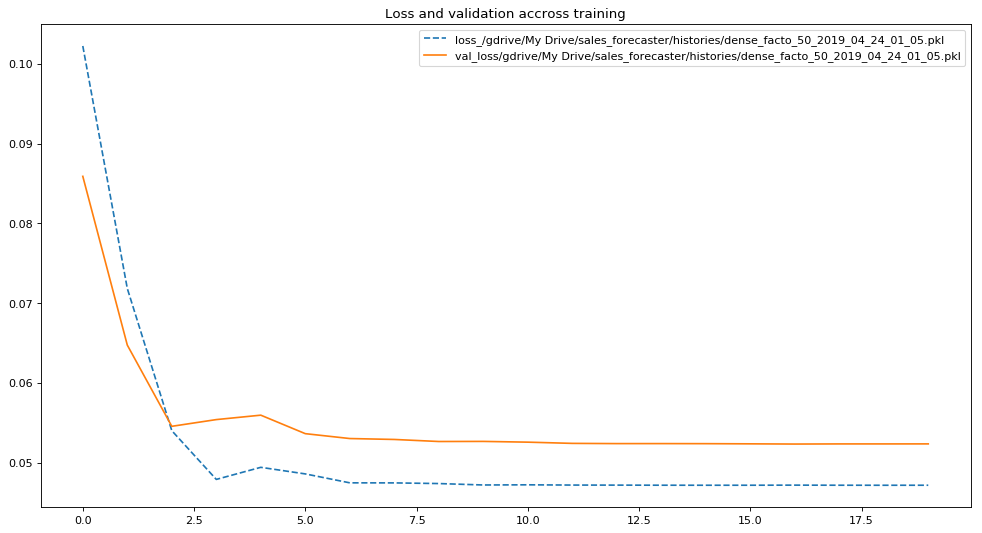

In [85]:
histories = [(main_path + '/histories/' + modname + '.pkl')]

plt.figure(num=None, figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')

for val in histories:
    print(val)
    with open(val , 'rb') as file_pi:
        thepickle = pickle.load(file_pi)
        plt.plot(thepickle["loss"],label ='loss_' + val,linestyle='--')
        plt.plot(thepickle["val_loss"],label='val_loss' + val)
        plt.legend(loc='upper right')
        plt.title("Loss and validation accross training")
        

pd.DataFrame(thepickle,columns =['loss','val_loss']).head(20).transpose()

Having completed training we can see that the model quickly converges to its optimal fit with the relatively flat validation loss accross all epochs of training.


Now we want to compare the models. Just below we define a function to find the history of the most recent run of each model type to compare the results

In [0]:
def find_last(string):
    hists = pd.DataFrame(os.listdir('/gdrive/My Drive/sales_forecaster/histories'))

    x = 0
    found = False
    while found != True:
      x = x-1
      found = hists.iloc[x].str.startswith(string).item()
   
    history = hists.iloc[x]
    
    return history

matrix_facto_50_2019_04_24_01_04.pkl
dense_facto_50_2019_04_24_01_05.pkl


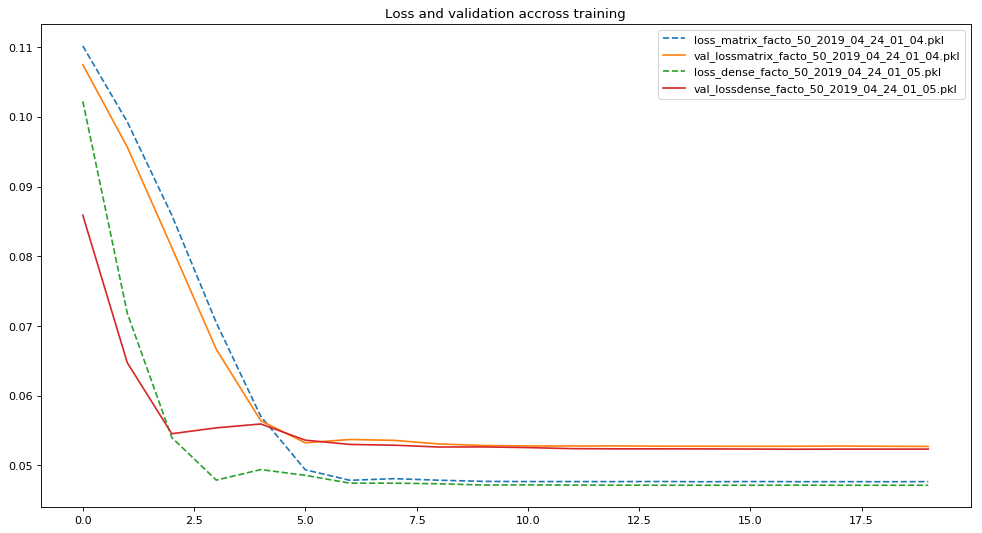

In [87]:
histories = []

histories.append(find_last('matrix').item())
histories.append(find_last('dense').item())

plt.figure(num=None, figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')

for val in histories:
    print(val)
    with open(main_path + '/histories/' + val , 'rb') as file_pi:
        thepickle = pickle.load(file_pi)
        plt.plot(thepickle["loss"],label ='loss_' + val,linestyle='--')
        plt.plot(thepickle["val_loss"],label='val_loss' + val)
        plt.legend(loc='upper right')
        plt.title("Loss and validation accross training")


This shows that although the training loss for both models is similar, although, the validation loss, hence, the actual performace of the deep model is somewhat superior.

Obviously, the performance improved significantly! Validation loss is practically cut in half. We can also notice the following points:


*   we converge really fast to the best model. After one or two epoch, the model starts overfitting or at least the validation loss does not seem to stabily go down anymore.
*   There is a large gap between training loss and validation loss (2.5 to 5 times depending on the model!), this suggests that maybe we could improve our performace by implementing a dropout layer or using a leaky ReLU / ELU activation function)



# Investigating embeddings

**Looking at most similar materials and customers**



In [88]:
print(df.head())

   old_customer_id             customer_name  customer_id  old_material_id  \
0              0.0  VIP STEEL  -   TRUGANINA          0.0         0.010763   
1              0.0  VIP STEEL  -   TRUGANINA          0.0         0.010763   
2              0.0  VIP STEEL  -   TRUGANINA          0.0         0.010763   
3              0.0  VIP STEEL  -   TRUGANINA          0.0         0.010763   
4              0.0  VIP STEEL  -   TRUGANINA          0.0         0.010763   

           material_name  material_id  period_material  order  
0  Food Beverage Closure          0.0         0.000000    0.0  
1  Food Beverage Closure          0.0         0.000545    0.0  
2  Food Beverage Closure          0.0         0.001090    0.0  
3  Food Beverage Closure          0.0         0.001635    0.0  
4  Food Beverage Closure          0.0         0.002180    0.0  


In [89]:
mats = pd.DataFrame(df['old_material_id'].unique(), columns=['materialID'])
mats = pd.merge(mats, material_codes, on='materialID')
print(mats.head(10))

material_info = pd.DataFrame()
material_info['name'] = mats['MaterialName']

material_info["map_id"]=mats["materialID"].map(inverse_material_map)
namesdic = {row[1]['material_id']:row[1]['material_name']  for row in df.iterrows()}

print(len(namesdic))

   materialID prodID                  MaterialName
0         1.0  AHC74                    HERBICIDES
1         0.0     AH  Agribusiness & Horticultural


/usr/local/lib/python3.6/dist-packages/pandas/core/reshape/merge.py:938: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  'representation', UserWarning)


153


In [90]:
material_info = pd.DataFrame()
material_info['material_name'] = df['material_name'] 
material_info['material_id'] = df['old_material_id']
print(material_info.columns)
material_info['map_id'] = material_info['material_id'].map(inverse_material_map)

namesdic = {row[1]['map_id']:row[1]['material_name']  for row in material_info.iterrows()}

print(material_info.head(10))


Index(['material_name', 'material_id'], dtype='object')
           material_name  material_id  map_id
0  Food Beverage Closure     0.010763     NaN
1  Food Beverage Closure     0.010763     NaN
2  Food Beverage Closure     0.010763     NaN
3  Food Beverage Closure     0.010763     NaN
4  Food Beverage Closure     0.010763     NaN
5  Food Beverage Closure     0.010763     NaN
6  Food Beverage Closure     0.010763     NaN
7  Food Beverage Closure     0.010763     NaN
8  Food Beverage Closure     0.010763     NaN
9  Food Beverage Closure     0.010763     NaN


In [91]:
load_path = main_path + "/models/"
model = load_model(load_path+modname + '.h5')
weights = model.get_weights()
user_embeddings = weights[0]
item_embeddings = weights[1]
print( "weights shapes",[w.shape for w in weights])

weights shapes [(6612, 30), (6612, 30), (60, 64), (64,), (64, 32), (32,), (32, 1), (1,)]


In [0]:
EPSILON = 1e-07

def cosine(x, y):
    dot_pdt = np.dot(x, y.T)
    norms = np.linalg.norm(x) * np.linalg.norm(y)
    return dot_pdt / (norms + EPSILON)


def cosine_similarities(x,embeddings):
    dot_pdt = np.dot(embeddings, x)
    norms = np.linalg.norm(x) * np.linalg.norm(embeddings,axis = 1)
    return dot_pdt / (norms + EPSILON)

# Computes euclidean distances between x and all item embeddings
def euclidean_distances(x,embeddings):  
    return np.linalg.norm(embeddings - x,axis=1)

# Computes top_n most similar items to an idx
def most_similar(idx, embeddings,top_n=10,euclidian= False):
    if euclidian:
        # eucliedian distance between idx and the rest
        distance = euclidean_distances(embeddings[idx],embeddings)
        order = (distance).argsort()
        order= [x for x in order if x != idx]
        order= order[:top_n]
        return list(zip([namesdic[x] for x in order], distance[order]))
    else: 
        # cosine similarity between idx and the rest
        distance = cosine_similarities(embeddings[idx],embeddings)
        order = (-distance).argsort()
        order= [x for x in order if x != idx]
        order= order[:top_n]
        return list(zip([namesdic[x] for x in order], distance[order]))

In [93]:
material_info = material_info.drop_duplicates()

print(material_info.head())

             material_name  material_id  map_id
0    Food Beverage Closure     0.010763     NaN
96       Specialty Closure     0.047133     NaN
228        MGB - Equipment     0.199666     NaN
288       General Line Can     0.530711     NaN
432             Steel Drum     0.575803     NaN


In [0]:
from IPython.core import display as ICD

dataframes = []
for i,row in enumerate(material_info.iterrows()):
    try:
      row = row[1]

      similars = pd.DataFrame(most_similar(row["map_id"],item_embeddings,top_n=10,euclidian= False))
      similars.columns = [row["material_name"]+' Closest',row["material_name"]+' Score' ]
      dataframes.append(similars)
      if i % 2 ==1 :
          final = pd.concat(dataframes,axis=1)
          ICD.display(final)
          dataframes=[]
    except:
      pass

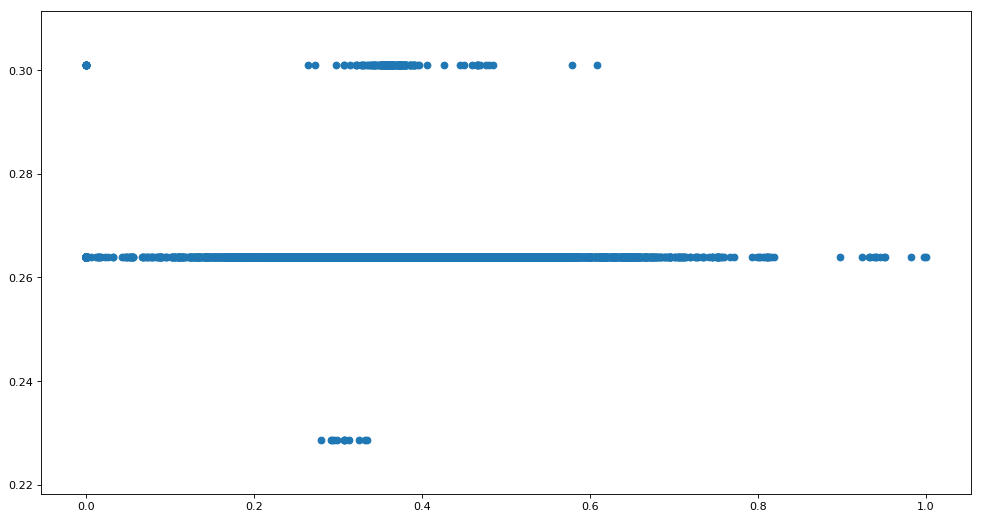

In [95]:
predictions = model.predict([df["customer_id"], df["material_id"]])

comparison = pd.concat([df['order'], pd.DataFrame(predictions).astype('float64').clip(0)], axis=1)
df['preditions'] = predictions

plt.figure(num=None, figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')

plt.scatter(df['order'], predictions)

df.to_csv('summary.csv')

In [96]:
load_path = main_path + "/models/"
model = load_model(load_path+modname + '.h5')
weights = model.get_weights()
customer_embeddings = weights[0]
materials_embeddings = weights[1]
print( "weights shapes",[w.shape for w in weights])

weights shapes [(6612, 30), (6612, 30), (60, 64), (64,), (64, 32), (32,), (32, 1), (1,)]


# Enhancing model architecture

The architecture defined above is simple. Indeed, it's either a dot product between embeddings or a concat layer before two dense layers. In the following we will try to gain performance by modifying the architecture of the network.

Here are a few idea I we are going to test:

* Change the dot/concat merge layer by a multiply. The idea here would be to relax the dot product so that the network can choose it's own weighted dot product, but at the same time keep the multipliction structure.
* The second idea is to try to improve the dot network by making it deeper. The problem is we cannot add a dense layer after the dot prodict since we are left with only one scalar value. An idea could be to add these dense layers before the dot product and have two "towers in" the architecture.
* We can use this idea with other architectures and create a network with two dense layers on embeddings, a concat layer, and then other dense layers.

Let's make this a little more concrete. With keras the first idea gives us:

## Experiment 1: Using Multiply merge layer instead of Concat.

This model implemented the same architecture as the previous Dense model with the exception of the input_vecs layer, the one that is used to concatnate the different inputs to then be fed through the Dense layers. 

By relaxing the dot product so that the network can choose it's own weighted dot product,it allows the model to keep the same multiplication struture while allow extra freedom to the Dense layers to factor in non-linearities.

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
customer (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
material (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
customer_embedding (Embedding)  (None, 1, 30)        198360      customer[0][0]                   
__________________________________________________________________________________________________
material_embedding (Embedding)  (None, 1, 30)        198360      material[0][0]                   
__________________________________________________________________________________________________
reshape (R

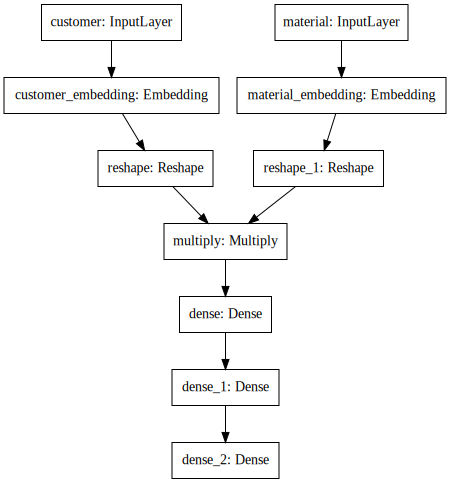

In [97]:
K.clear_session()

customer_id_input = Input(shape=[1], name='customer')
material_id_input = Input(shape=[1], name = 'material')

embedding_size=30

customer_embedding = Embedding(output_dim=embedding_size, input_dim=df.shape[0],
                             input_length=1, name='customer_embedding')(customer_id_input)
material_embedding = Embedding(output_dim=embedding_size, input_dim=df.shape[0],
                             input_length=1, name='material_embedding')(material_id_input)

customer_vecs = Reshape([embedding_size])(customer_embedding)
material_vecs = Reshape([embedding_size])(material_embedding)

#customer_vecs = Dense(64, activation='relu')(customer_vecs)
#material_vecs = Dense(64, activation='relu')(material_vecs)

input_vecs = Multiply()([customer_vecs, material_vecs])
#input_vecs = Dropout(0.2)(input_vecs)

x = Dense(64, activation='relu')(input_vecs)
x = Dense(32, activation='relu')(x)

y = Dense(1)(x)

model = Model(inputs=[customer_id_input, material_id_input], outputs=y)
model.compile(optimizer='adam', loss='mse')

print(model.summary())
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [0]:
save_path = main_path + "/models"
mytime = time.strftime("%Y_%m_%d_%H_%M")
modname = 'multiply_facto_50_' + mytime 
thename = save_path + '/' + modname + '.h5'
mcheck = ModelCheckpoint(thename  , monitor='val_loss', save_best_only=True)

In [99]:
history = model.fit([df["customer_id"], df["material_id"]]
                    , df["order"]
                    , batch_size=128 * 8, epochs=epochs
                    , validation_split=0.1
                    , callbacks=[mcheck]
                    , shuffle=True)

with open(main_path + '/histories/' + modname + '.pkl' , 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

Train on 5950 samples, validate on 662 samples
Epoch 1/20
5950/5950 [==============================] - 1s 119us/sample - loss: 0.1108 - val_loss: 0.1029
Epoch 2/20
5950/5950 [==============================] - 0s 24us/sample - loss: 0.0929 - val_loss: 0.0861
Epoch 3/20
5950/5950 [==============================] - 0s 37us/sample - loss: 0.0763 - val_loss: 0.0711
Epoch 4/20
5950/5950 [==============================] - 0s 30us/sample - loss: 0.0620 - val_loss: 0.0597
Epoch 5/20
5950/5950 [==============================] - 0s 30us/sample - loss: 0.0521 - val_loss: 0.0535
Epoch 6/20
5950/5950 [==============================] - 0s 33us/sample - loss: 0.0477 - val_loss: 0.0527
Epoch 7/20
5950/5950 [==============================] - 0s 13us/sample - loss: 0.0477 - val_loss: 0.0539
Epoch 8/20
5950/5950 [==============================] - 0s 15us/sample - loss: 0.0483 - val_loss: 0.0537
Epoch 9/20
5950/5950 [==============================] - 0s 12us/sample - loss: 0.0477 - val_loss: 0.0528
Epoch 1

/gdrive/My Drive/sales_forecaster/histories/multiply_facto_50_2019_04_24_01_05.pkl


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
loss,0.110764,0.092918,0.076322,0.062017,0.052124,0.047691,0.047742,0.048275,0.047721,0.047238,0.047246,0.047286,0.047246,0.047194,0.047186,0.047194,0.047189,0.047183,0.047181,0.047181
val_loss,0.102923,0.086081,0.071069,0.059663,0.053504,0.052746,0.053942,0.053680,0.052815,0.052497,0.052499,0.052485,0.052470,0.052499,0.052512,0.052512,0.052473,0.052453,0.052452,0.052455


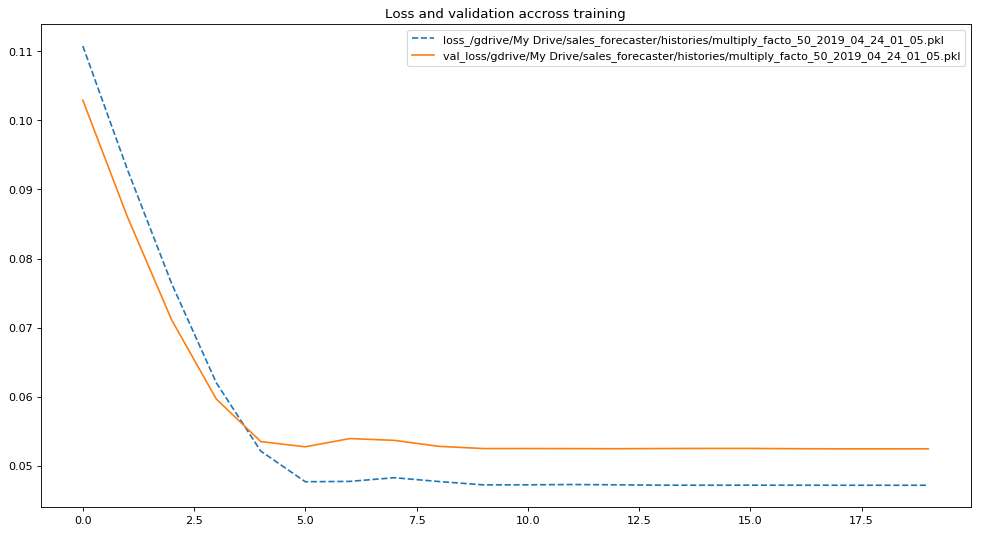

In [100]:
histories = [(main_path + '/histories/' + modname + '.pkl')]

plt.figure(num=None, figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')

for val in histories:
    print(val)
    with open(val , 'rb') as file_pi:
        thepickle = pickle.load(file_pi)
        plt.plot(thepickle["loss"],label ='loss_' + val,linestyle='--')
        plt.plot(thepickle["val_loss"],label='val_loss' + val)
        plt.legend(loc='upper right')
        plt.title("Loss and validation accross training")
        

pd.DataFrame(thepickle,columns =['loss','val_loss']).head(20).transpose()

matrix_facto_50_2019_04_24_01_04.pkl
dense_facto_50_2019_04_24_01_05.pkl
multiply_facto_50_2019_04_24_01_05.pkl


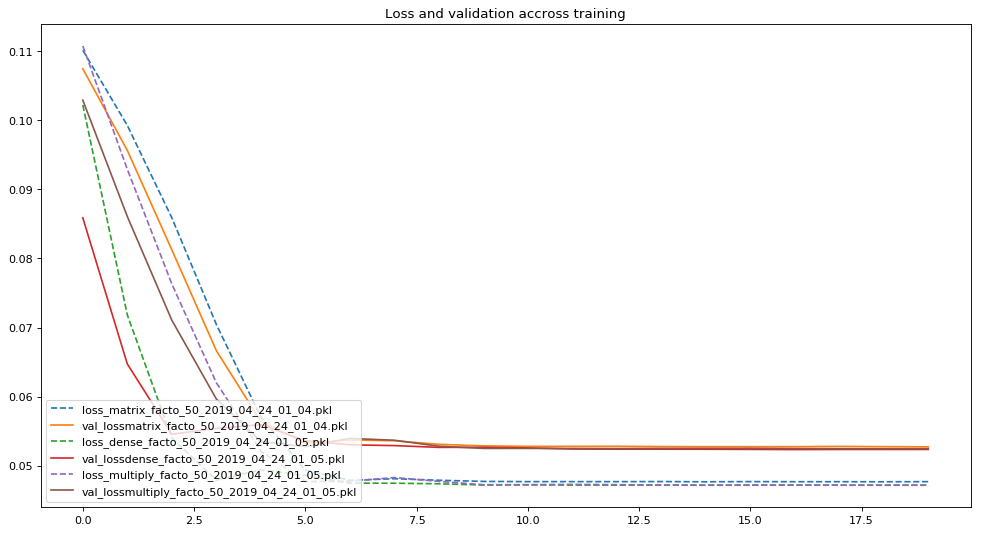

In [101]:
histories = []

histories.append(find_last('matrix').item())
histories.append(find_last('dense').item())
histories.append(find_last('multiply').item())

plt.figure(num=None, figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')

for val in histories:
    print(val)
    with open(main_path + '/histories/' + val , 'rb') as file_pi:
        thepickle = pickle.load(file_pi)
        plt.plot(thepickle["loss"],label ='loss_' + val,linestyle='--')
        plt.plot(thepickle["val_loss"],label='val_loss' + val)
        plt.legend(loc='lower left')
        plt.title("Loss and validation accross training")

## Experiment 2: Adding a dropout layer

Large neural nets trained on relatively small datasets can overfit the training data.

This has the effect of the model learning the statistical noise in the training data, which results in poor performance when the model is evaluated on new data, e.g. a test dataset. Generalization error increases due to overfitting.

Dropout is a regularization method that approximates training a large number of neural networks with different architectures in parallel.

During training, some number of layer outputs are randomly ignored or “dropped out.” This has the effect of making the layer look-like and be treated-like a layer with a different number of nodes and connectivity to the prior layer. In effect, each update to a layer during training is performed with a different “view” of the configured layer.

By dropping a unit out, we mean temporarily removing it from the network, along with all its incoming and outgoing connections

Dropout has the effect of making the training process noisy, forcing nodes within a layer to probabilistically take on more or less responsibility for the inputs.

This conceptualization suggests that perhaps dropout breaks-up situations where network layers co-adapt to correct mistakes from prior layers, in turn making the model more robust.

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
customer (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
material (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
customer_embedding (Embedding)  (None, 1, 30)        198360      customer[0][0]                   
__________________________________________________________________________________________________
material_embedding (Embedding)  (None, 1, 30)        198360      material[0][0]                   
__________________________________________________________________________________________________
reshape (R

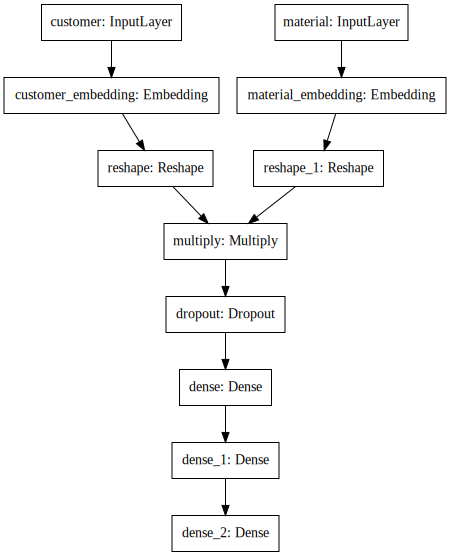

In [102]:
K.clear_session()

customer_id_input = Input(shape=[1], name='customer')
material_id_input = Input(shape=[1], name = 'material')

embedding_size=30

customer_embedding = Embedding(output_dim=embedding_size, input_dim=df.shape[0],
                             input_length=1, name='customer_embedding')(customer_id_input)
material_embedding = Embedding(output_dim=embedding_size, input_dim=df.shape[0],
                             input_length=1, name='material_embedding')(material_id_input)

customer_vecs = Reshape([embedding_size])(customer_embedding)
material_vecs = Reshape([embedding_size])(material_embedding)

#customer_vecs = Dense(64, activation='relu')(customer_vecs)
#material_vecs = Dense(64, activation='relu')(material_vecs)

input_vecs = Multiply()([customer_vecs, material_vecs])
input_vecs = Dropout(0.2)(input_vecs)

x = Dense(64, activation='relu')(input_vecs)
x = Dense(32, activation='relu')(x)

y = Dense(1)(x)

model = Model(inputs=[customer_id_input, material_id_input], outputs=y)
model.compile(optimizer='adam', loss='mse')

print(model.summary())
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [0]:
save_path = main_path + "/models"
mytime = time.strftime("%Y_%m_%d_%H_%M")
modname = 'dropout_towers_50_' + mytime 
thename = save_path + '/' + modname + '.h5'
mcheck = ModelCheckpoint(thename  , monitor='val_loss', save_best_only=True)

In [104]:
history = model.fit([df["customer_id"], df["material_id"]]
                    , df["order"]
                    , batch_size=128 * 8, epochs=epochs
                    , validation_split=0.1
                    , callbacks=[mcheck]
                    , shuffle=True)

with open(main_path + '/histories/' + modname + '.pkl' , 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

Train on 5950 samples, validate on 662 samples
Epoch 1/20
5950/5950 [==============================] - 1s 121us/sample - loss: 0.1108 - val_loss: 0.1026
Epoch 2/20
5950/5950 [==============================] - 0s 24us/sample - loss: 0.0924 - val_loss: 0.0851
Epoch 3/20
5950/5950 [==============================] - 0s 37us/sample - loss: 0.0751 - val_loss: 0.0696
Epoch 4/20
5950/5950 [==============================] - 0s 29us/sample - loss: 0.0605 - val_loss: 0.0583
Epoch 5/20
5950/5950 [==============================] - 0s 29us/sample - loss: 0.0509 - val_loss: 0.0529
Epoch 6/20
5950/5950 [==============================] - 0s 13us/sample - loss: 0.0474 - val_loss: 0.0531
Epoch 7/20
5950/5950 [==============================] - 0s 12us/sample - loss: 0.0479 - val_loss: 0.0541
Epoch 8/20
5950/5950 [==============================] - 0s 12us/sample - loss: 0.0483 - val_loss: 0.0534
Epoch 9/20
5950/5950 [==============================] - 0s 22us/sample - loss: 0.0476 - val_loss: 0.0526
Epoch 1

/gdrive/My Drive/sales_forecaster/histories/dropout_towers_50_2019_04_24_01_05.pkl


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
loss,0.110835,0.092443,0.075122,0.060533,0.050866,0.047438,0.047935,0.048311,0.047555,0.047206,0.047238,0.047273,0.047214,0.047203,0.047203,0.047184,0.047179,0.047188,0.047189,0.047175
val_loss,0.102609,0.085091,0.069635,0.058290,0.052913,0.053064,0.054120,0.053435,0.052646,0.052453,0.052467,0.052446,0.052442,0.052478,0.052487,0.052461,0.052444,0.052438,0.052430,0.052435


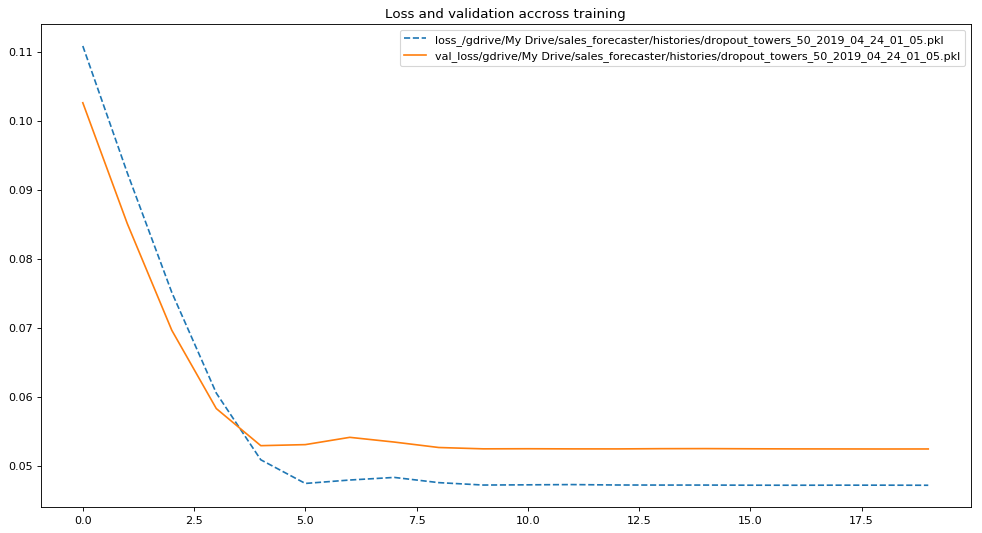

In [105]:
histories = [(main_path + '/histories/' + modname + '.pkl')]

plt.figure(num=None, figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')

for val in histories:
    print(val)
    with open(val , 'rb') as file_pi:
        thepickle = pickle.load(file_pi)
        plt.plot(thepickle["loss"],label ='loss_' + val,linestyle='--')
        plt.plot(thepickle["val_loss"],label='val_loss' + val)
        plt.legend(loc='upper right')
        plt.title("Loss and validation accross training")
        

pd.DataFrame(thepickle,columns =['loss','val_loss']).head(20).transpose()

matrix_facto_50_2019_04_24_01_04.pkl
dense_facto_50_2019_04_24_01_05.pkl
multiply_facto_50_2019_04_24_01_05.pkl
dropout_towers_50_2019_04_24_01_05.pkl


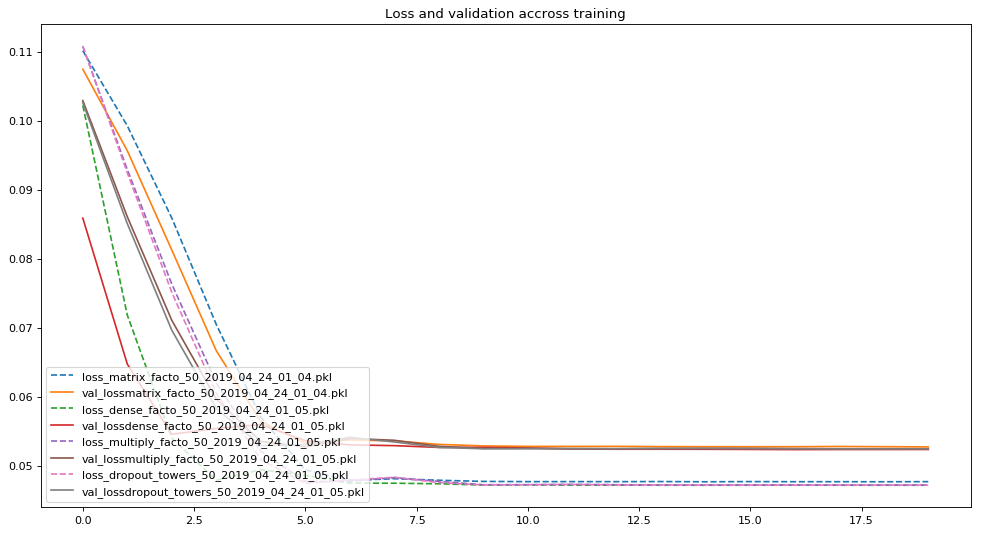

In [106]:
histories = []

histories.append(find_last('matrix').item())
histories.append(find_last('dense').item())
histories.append(find_last('multiply').item())
histories.append(find_last('dropout').item())

plt.figure(num=None, figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')

for val in histories:
    print(val)
    with open(main_path + '/histories/' + val , 'rb') as file_pi:
        thepickle = pickle.load(file_pi)
        plt.plot(thepickle["loss"],label ='loss_' + val,linestyle='--')
        plt.plot(thepickle["val_loss"],label='val_loss' + val)
        plt.legend(loc='lower left')
        plt.title("Loss and validation accross training")

As we can see here by adding a dropout layer we can somewhat reduce the effects of overtraining allowing us to create more complex models

## Experiement 3: Increase model depth

By making a model deeper we increase its potential power. 

The problem is that we cannot adda dense layer after the dot product since we are left with only one scalar value. Therefore, we shall instead add these dense layers before the dot product creating two "towers" in the architecture.

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
customer (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
material (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
customer_embedding (Embedding)  (None, 1, 30)        198360      customer[0][0]                   
__________________________________________________________________________________________________
material_embedding (Embedding)  (None, 1, 30)        198360      material[0][0]                   
__________________________________________________________________________________________________
reshape (R

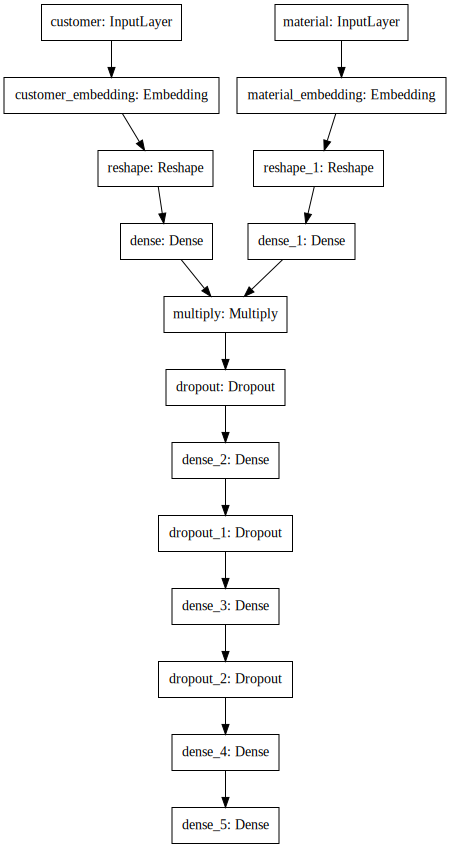

In [118]:
K.clear_session()

customer_id_input = Input(shape=[1], name='customer')
material_id_input = Input(shape=[1], name = 'material')

embedding_size=30

customer_embedding = Embedding(output_dim=embedding_size, input_dim=df.shape[0],
                             input_length=1, name='customer_embedding')(customer_id_input)
material_embedding = Embedding(output_dim=embedding_size, input_dim=df.shape[0],
                             input_length=1, name='material_embedding')(material_id_input)

customer_vecs = Reshape([embedding_size])(customer_embedding)
material_vecs = Reshape([embedding_size])(material_embedding)

customer_vecs = Dense(64, activation='relu')(customer_vecs)
material_vecs = Dense(64, activation='relu')(material_vecs)

input_vecs = Multiply()([customer_vecs, material_vecs])
input_vecs = Dropout(0.2)(input_vecs)

x = Dense(128, activation='relu')(input_vecs)
x = Dropout(0.2)(x) # Add droupout or not 
x = Dense(64, activation='relu')(x) # Add dense again or not 
x = Dropout(0.2)(x) # Add droupout or not 
x = Dense(32, activation='relu')(x) # Add dense again or not 

y = Dense(1)(x)

model = Model(inputs=[customer_id_input, material_id_input], outputs=y)
adam = Adam(lr=0.0001)
model.compile(optimizer=adam, loss='mse')

print(model.summary())
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [0]:
save_path = main_path + "/models"
mytime = time.strftime("%Y_%m_%d_%H_%M")
modname = 'towers_50_' + mytime 
thename = save_path + '/' + modname + '.h5'
mcheck = ModelCheckpoint(thename  , monitor='val_loss', save_best_only=True)

In [120]:
history = model.fit([df["customer_id"], df["material_id"]]
                    , df["order"]
                    , batch_size=128 * 8, epochs=epochs
                    , validation_split=0.1
                    , callbacks=[mcheck]
                    , shuffle=True)

with open(main_path + '/histories/' + modname + '.pkl' , 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

Train on 5950 samples, validate on 662 samples
Epoch 1/20
5950/5950 [==============================] - 1s 186us/sample - loss: 0.1174 - val_loss: 0.1187
Epoch 2/20
5950/5950 [==============================] - 0s 37us/sample - loss: 0.1153 - val_loss: 0.1165
Epoch 3/20
5950/5950 [==============================] - 0s 39us/sample - loss: 0.1131 - val_loss: 0.1141
Epoch 4/20
5950/5950 [==============================] - 0s 35us/sample - loss: 0.1107 - val_loss: 0.1117
Epoch 5/20
5950/5950 [==============================] - 0s 35us/sample - loss: 0.1082 - val_loss: 0.1092
Epoch 6/20
5950/5950 [==============================] - 0s 34us/sample - loss: 0.1057 - val_loss: 0.1066
Epoch 7/20
5950/5950 [==============================] - 0s 37us/sample - loss: 0.1030 - val_loss: 0.1039
Epoch 8/20
5950/5950 [==============================] - 0s 35us/sample - loss: 0.1003 - val_loss: 0.1011
Epoch 9/20
5950/5950 [==============================] - 0s 40us/sample - loss: 0.0975 - val_loss: 0.0982
Epoch 1

/gdrive/My Drive/sales_forecaster/histories/towers_50_2019_04_24_01_11.pkl


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
loss,0.117427,0.115342,0.113068,0.110730,0.108243,0.105703,0.103009,0.100300,0.097510,0.094582,0.091579,0.088307,0.085231,0.081891,0.078584,0.075236,0.071769,0.068593,0.06528,0.062100
val_loss,0.118657,0.116451,0.114115,0.111687,0.109168,0.106561,0.103878,0.101101,0.098243,0.095289,0.092236,0.089104,0.085913,0.082686,0.079426,0.076176,0.072942,0.069728,0.06660,0.063639


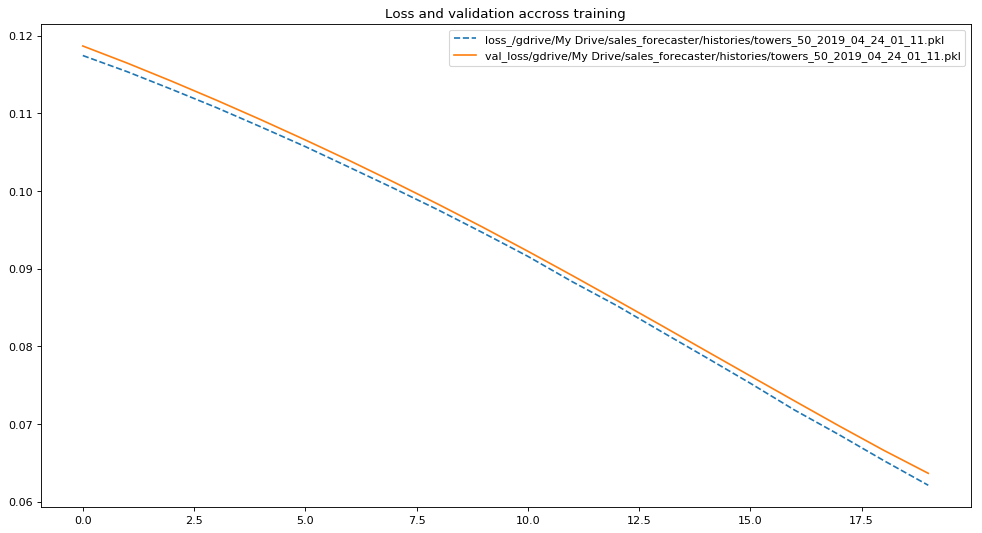

In [121]:
histories = [(main_path + '/histories/' + modname + '.pkl')]

plt.figure(num=None, figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')

for val in histories:
    print(val)
    with open(val , 'rb') as file_pi:
        thepickle = pickle.load(file_pi)
        plt.plot(thepickle["loss"],label ='loss_' + val,linestyle='--')
        plt.plot(thepickle["val_loss"],label='val_loss' + val)
        plt.legend(loc='upper right')
        plt.title("Loss and validation accross training")
        

pd.DataFrame(thepickle,columns =['loss','val_loss']).head(20).transpose()

matrix_facto_50_2019_04_24_01_04.pkl
dense_facto_50_2019_04_24_01_05.pkl
multiply_facto_50_2019_04_24_01_05.pkl
dropout_towers_50_2019_04_24_01_05.pkl
towers_50_2019_04_24_01_11.pkl


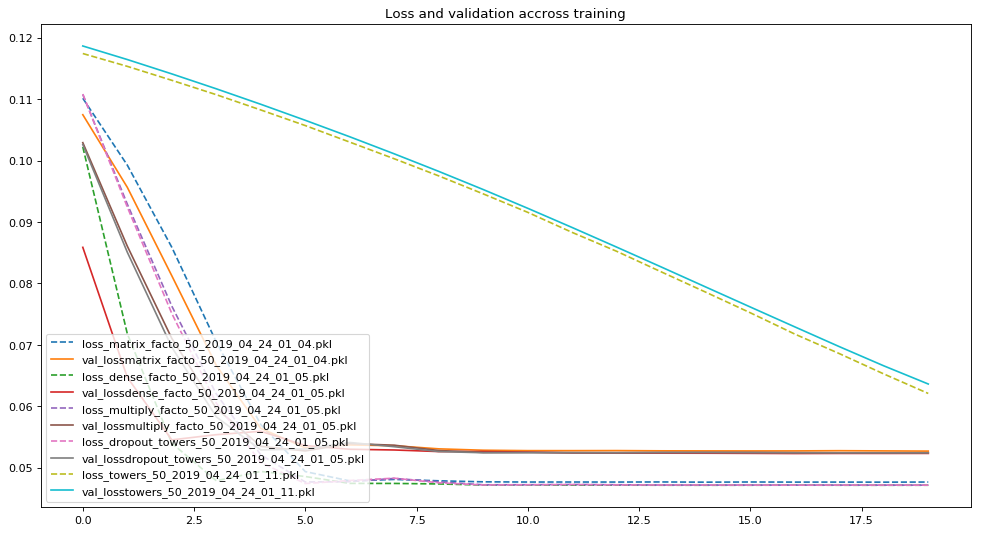

In [122]:
histories = []

histories.append(find_last('matrix').item())
histories.append(find_last('dense').item())
histories.append(find_last('multiply').item())
histories.append(find_last('dropout').item())
histories.append(find_last('towers').item())

plt.figure(num=None, figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')

for val in histories:
    print(val)
    with open(main_path + '/histories/' + val , 'rb') as file_pi:
        thepickle = pickle.load(file_pi)
        plt.plot(thepickle["loss"],label ='loss_' + val,linestyle='--')
        plt.plot(thepickle["val_loss"],label='val_loss' + val)
        plt.legend(loc='lower left')
        plt.title("Loss and validation accross training")

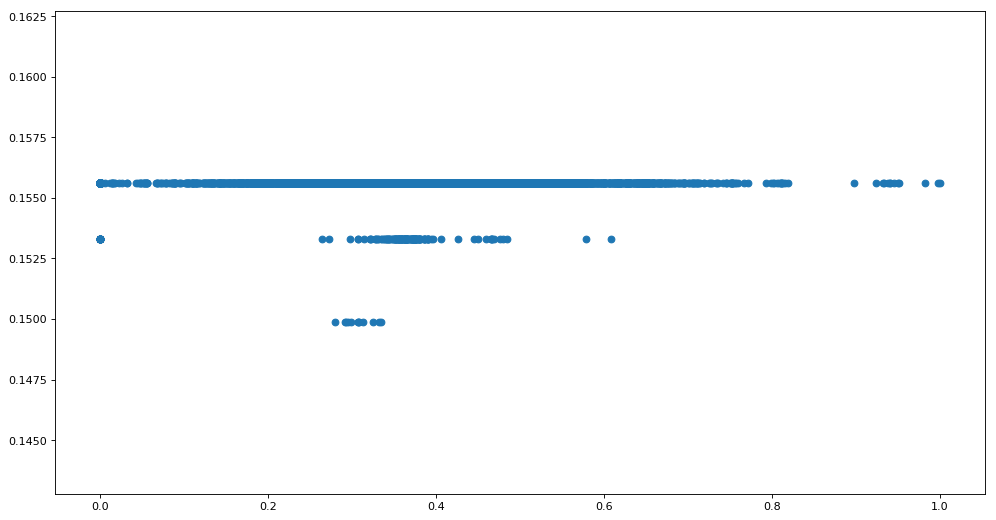

In [123]:
predictions = model.predict([df["customer_id"], df["material_id"]])

comparison = pd.concat([df['order'], pd.DataFrame(predictions).astype('float64').clip(0)], axis=1)
df['preditions'] = predictions

plt.figure(num=None, figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')

plt.scatter(df['order'], predictions)
